# Imports

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import optuna as opt
from scipy import stats

/opt/miniconda3/envs/intro-ai/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/miniconda3/envs/intro-ai/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Importing the data

In [2]:
# Import the data in ./../data/
df = pd.read_csv("./../Data/space.csv")
df.head(3)

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598370,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513


# Categorically Encoding "class"

In [3]:
# Use pandas cat.codes to convert the categorical data to numerical data, this is because xgboost only accepts numerical data as 
# the input in classification problems.
df["class"] = pd.Categorical(df["class"]).codes
df["class"]

0       2
1       2
2       0
3       2
4       2
       ..
9995    0
9996    0
9997    2
9998    0
9999    0
Name: class, Length: 10000, dtype: int8

<AxesSubplot:>

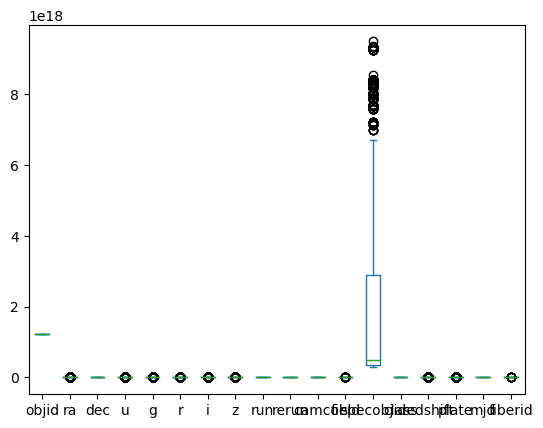

In [4]:
df.plot.box()

In [5]:
# Define X and y

df2 = df.drop(["class"], axis=1)

X = df2
y = df["class"]

# Train_test_split 

In [6]:
# Split the data into train and test sets with test_size=0.2 and random_state=42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optuna hyperparameter optimalization

In [7]:
def objective(trial):
    param = {
            "n_estimators" : trial.suggest_int('n_estimators', 0, 1000),
            'max_depth':trial.suggest_int('max_depth', 2, 25),
            'reg_alpha':trial.suggest_int('reg_alpha', 0, 5),
            'reg_lambda':trial.suggest_int('reg_lambda', 0, 5),
            'min_child_weight':trial.suggest_int('min_child_weight', 0, 5),
            'gamma':trial.suggest_int('gamma', 0, 5),
            'learning_rate':trial.suggest_loguniform('learning_rate',0.005,0.5),
            'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.1,1,0.01),
            'nthread' : -1
        }
    model = xgb.XGBClassifier(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return f1_score( y_test, y_pred, average='macro')


In [8]:
# Create a Optuna study object with .create_study() and set the direction to maximize, this is because we want to maximize the f1 score.
# Then, run the study with .optimize() and pass the objective function and the number of trials as parameters.
study = opt.create_study(direction="maximize")
study.optimize(objective, n_trials=3)

[I 2022-10-12 11:46:44,589] A new study created in memory with name: no-name-aebe22f1-6a23-4496-9a22-ad5d733309e8
/var/folders/6s/94cj8dh53f76lqyqy2psnzcr0000gn/T/ipykernel_62156/2764666875.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate':trial.suggest_loguniform('learning_rate',0.005,0.5),
/var/folders/6s/94cj8dh53f76lqyqy2psnzcr0000gn/T/ipykernel_62156/2764666875.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.1,1,0.01),
/opt/miniconda3/envs/intro-ai/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in 

[11:46:44] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-10-12 11:46:54,936] Trial 0 finished with value: 0.9876028344668701 and parameters: {'n_estimators': 979, 'max_depth': 16, 'reg_alpha': 2, 'reg_lambda': 2, 'min_child_weight': 3, 'gamma': 1, 'learning_rate': 0.10718689977545201, 'colsample_bytree': 0.75}. Best is trial 0 with value: 0.9876028344668701.
/var/folders/6s/94cj8dh53f76lqyqy2psnzcr0000gn/T/ipykernel_62156/2764666875.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate':trial.suggest_loguniform('learning_rate',0.005,0.5),
/var/folders/6s/94cj8dh53f76lqyqy2psnzcr0000gn/T/ipykernel_62156/2764666875.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'colsamp

[11:46:54] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-10-12 11:46:58,309] Trial 1 finished with value: 0.9825175621695198 and parameters: {'n_estimators': 509, 'max_depth': 23, 'reg_alpha': 4, 'reg_lambda': 2, 'min_child_weight': 2, 'gamma': 5, 'learning_rate': 0.2654559340119238, 'colsample_bytree': 0.27}. Best is trial 0 with value: 0.9876028344668701.
/var/folders/6s/94cj8dh53f76lqyqy2psnzcr0000gn/T/ipykernel_62156/2764666875.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate':trial.suggest_loguniform('learning_rate',0.005,0.5),
/var/folders/6s/94cj8dh53f76lqyqy2psnzcr0000gn/T/ipykernel_62156/2764666875.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'colsampl

[11:46:58] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-10-12 11:47:07,576] Trial 2 finished with value: 0.9832599775056762 and parameters: {'n_estimators': 834, 'max_depth': 15, 'reg_alpha': 2, 'reg_lambda': 2, 'min_child_weight': 4, 'gamma': 5, 'learning_rate': 0.01106532997413688, 'colsample_bytree': 0.58}. Best is trial 0 with value: 0.9876028344668701.


# Using optuna hyperparams to make a model

In [9]:
# Retrieve the best parameters from the study with .best_params
# And create a XGBoost classifier with the best parameters, then fit the model with the training data
bparams = study.best_params
model2 = xgb.XGBClassifier(bparams)
model2.fit(X_train, y_train)


/opt/miniconda3/envs/intro-ai/lib/python3.8/site-packages/xgboost/core.py:499: FutureWarning: Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(
/opt/miniconda3/envs/intro-ai/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/miniconda3/envs/intro-ai/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:47:07] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

# Predicting on the test set with the model

In [10]:
# Predict the test data
preds = model2.predict(X_test)


# Using cross-validation to get an accurate score

In [11]:
# Use cross_val_score to get the cross validation score of the model with the training data.
# Cross validation is a technique to evaluate the performance of a model on unseen data, it is done by splitting the data into "k" folds
# and then training the model on "k-1" folds and testing it on the remaining fold. This is repeated "k" times and the average of the
# scores is taken as the final score. This effectively means that the data is trained and validated on all of the data.
# Run cross_val_score with 5 folds and scoring='f1_macro'

scores = cross_val_score(model2, X_test, y_test, cv=5, scoring='f1_macro')


/opt/miniconda3/envs/intro-ai/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/miniconda3/envs/intro-ai/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/miniconda3/envs/intro-ai/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following:

[11:47:08] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:47:08] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/miniconda3/envs/intro-ai/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/miniconda3/envs/intro-ai/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/opt/miniconda3/envs/intro-ai/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following:

[11:47:08] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:47:09] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:47:09] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to

/opt/miniconda3/envs/intro-ai/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/miniconda3/envs/intro-ai/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [12]:
# Print the mean and standard deviation of the scores, this is a good way to evaluate the performance of the model.

import statistics

print(statistics.mean(scores))
print(statistics.stdev(scores))

0.9766043690909211
0.014576746435182213


# Plot the feature importances

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

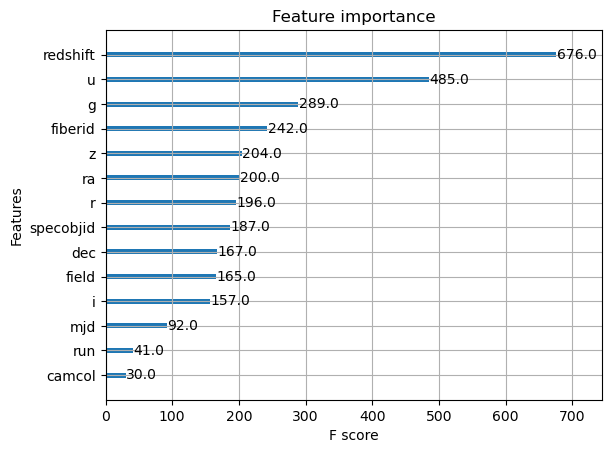

In [13]:
# XGBoost has a built in function to plot the feature importance, use it to plot the feature importance of the model.
# Feature importance shows how much each feature contributes to the model, this is a good way to see which features are important

xgb.plot_importance(model2)

# Plotting the confusion matrix

In [14]:
model2.classes_

array([0, 1, 2], dtype=int8)

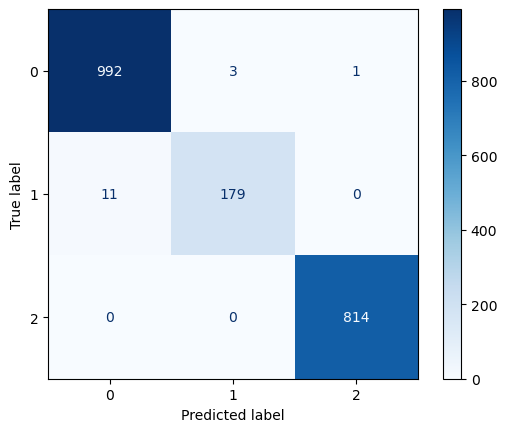

In [15]:
# A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") 
# on a set of test data for which the true values are known. The confusion matrix itself is relatively simple to understand,
# but the related terminology can be confusing. The confusion matrix shows the ways in which your classification model is confused
# when it makes predictions. It gives you insight not only into the errors being made by your classifier but more importantly
# the types of errors that are being made.

# Get the confusion matrix from sklearn.metric.confusion_metric and plot it with ConfusionMatrixDisplay
# Make sure to include display_labels with the class names (HINT: model.classes_) to make the plot more readable

cm = confusion_matrix(y_true=y_test, y_pred=preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model2.classes_)

disp.plot(cmap='Blues')

# Plot a tree from the model

ImportError: You must install graphviz to plot tree

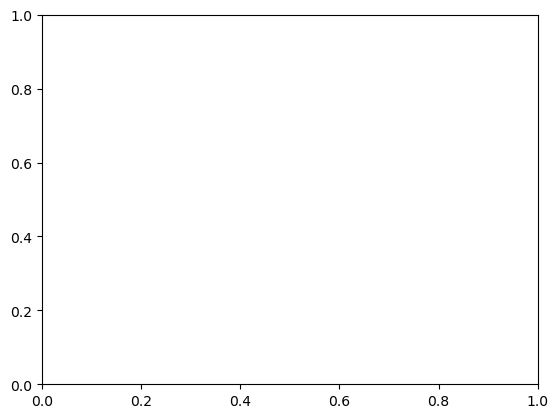

In [28]:
# XGBoost is a tree based ensemble model, it is always a good idea to visualize the tree to see how the model is making the predictions.
# Use xgb.to_graphviz to visualize the tree and save it as a png file.
from graphviz import Source

xgb.plot_tree(model2)